In [1]:
%load_ext autoreload
%autoreload 2

Deep Q Network for UAV-0 MIMO environment

In this notebook, a DQN network is implemented for openAI gym's UAV environment



In [2]:
import gym
import gym_uav
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
import math

from tensorboardX import SummaryWriter

In [3]:
log = gym.logger
log.set_level(gym.logger.INFO)

#Tensorboard Writer
writer = SummaryWriter()

env = gym.make('uav-v0')
env.seed(0)
state_size = env.obs_space.shape[0]
action_size = env.act_space.n
print('State shape: ', env.obs_space.shape)
print('Number of actions: ', env.act_space.n)

INFO: Making new env: uav-v0
State shape:  (3,)
Number of actions:  8


In [17]:
from Source.dqn_agent import Agent
from Source.NN_model import QNetwork

agent = Agent(state_size=state_size, action_size=action_size, seed=0)
print(QNetwork(state_size, action_size, seed=0))
# watch an untrained agent
state = env.reset()
#print(state)
for j in range(5):
    action, qval = agent.act(state)
    #print("Action: {}, Qval: {}".format(action, qval))
    #env.render()
    #print("[NB] action: {}".format(action))
    state, reward, done, _ = env.step(action)
    if done:
        break 
        
env.close()

QNetwork(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=3, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=32, bias=True)
  )
  (output): Linear(in_features=32, out_features=8, bias=True)
)


Train the Agent with DQN

Episode 100	Average Score: 6.50
Episode 200	Average Score: 9.994
Episode 300	Average Score: 10.75
Episode 400	Average Score: 14.94
Episode 500	Average Score: 16.10
Episode 600	Average Score: 15.93
Episode 700	Average Score: 18.05
Episode 800	Average Score: 19.24
Episode 900	Average Score: 19.24
Episode 1000	Average Score: 20.56
Episode 1100	Average Score: 20.63
Episode 1200	Average Score: 20.52
Episode 1300	Average Score: 19.55
Episode 1400	Average Score: 20.05
Episode 1500	Average Score: 19.16
Episode 1600	Average Score: 21.17
Episode 1700	Average Score: 20.95
Episode 1800	Average Score: 19.80
Episode 1900	Average Score: 21.37
Episode 2000	Average Score: 19.89
Episode 2100	Average Score: 20.69
Episode 2200	Average Score: 20.68
Episode 2300	Average Score: 21.27
Episode 2400	Average Score: 21.03
Episode 2500	Average Score: 19.85
Episode 2600	Average Score: 22.05
Episode 2700	Average Score: 21.86
Episode 2800	Average Score: 21.50
Episode 2900	Average Score: 22.39
Episode 3000	Average Sco

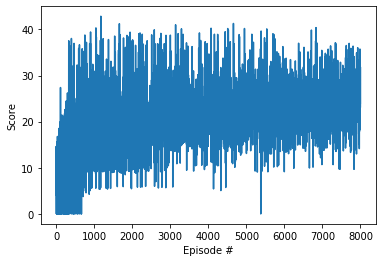

In [5]:
def dqn_train(n_episodes=8000, eps_start=1.000, eps_end=.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []      #list containing scores from each episode
    scores_window = deque(maxlen=100) #last 100 scores
    eps = eps_start
    max_t = 5
    ep_qvals = []
    for i_episode in range(1, n_episodes+1):
        state = env.reset() # normalized state
        score = 0.0
        ep_qval = []
        ep_loss = []
        for t in range(max_t):
            action, qval = agent.act(state, eps)
            
            #print("Action: {}, Qval: {}".format(action, qval))
            next_state, reward, done, _ = env.step(action)
            #print("reward: ", reward)
            loss = agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            ep_qval.append(qval)
            if loss is not None:
                ep_loss.append(loss)
            if done:
                break
        scores_window.append(score)
        scores.append(score)
        ep_qvals.append(np.mean(ep_qval))
    
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        writer.add_scalar("train/avg_ep_qval", np.mean(ep_qval), i_episode)
        writer.add_scalar("train/epsilon", eps, i_episode)
        writer.add_scalar("train/ep_score", score, i_episode)
        writer.add_scalar("train/ep_loss", np.sum(ep_loss), i_episode)
        
        #eps = eps_end + (eps_start-eps_end)*math.exp(-1*i_episode/eps_decay)
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if i_episode % n_episodes == 0: #np.mean(scores_window)>=200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

scores = dqn_train()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

Testing the DQN Agent

In [6]:
#Load the weights from file
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

test_episodes = 20
max_t = 5
gamma = 0.99

rate_acc_los_scores = []
rate_acc_exh_scores = []
learnt_val_fns = []
true_val_fns = []
test_scores = []
agent.qnetwork_local.eval()
for i_episode in range(1, test_episodes+1):
    
    learnt_rates = 0.0
    los_rates = 0.0
    exh_rates = 0.0
    state = env.reset()
    learnt_val_fn = 0.0
    true_val_fn = 0.0
    perf_score = 0
    for t in range(max_t):
        action, qval = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        
        state = state * env.high_obs
        next_state = next_state * env.high_obs
        
        curr_loc = (state[0]*np.cos(state[1]), state[0]*np.sin(state[1]))
        next_loc = (next_state[0]*np.cos(next_state[1]), next_state[0]*np.sin(next_state[1]))
        #print("Test Episode: {2}, Current Location: {0}, Next Location: {1}".format(curr_loc, next_loc, i_episode))
        #print("Learnt Action: ", test_net(state))
        
            
        next_state = next_state / env.high_obs
        
        #rate measurements
        learnt_rate = env.get_Rate()
        _,los_rate = env.get_Los_Rate(next_state)
        exh_bdir,exh_rate = env.get_Exh_Rate(next_state)
        
        if (learnt_rate > env.rate_threshold):
            perf_score +=1
        learnt_val_fn += ((gamma**t) * (learnt_rate))
        true_val_fn += ((gamma**t) * (exh_rate))
        
        print("exh dir: {0}, learnt bdir: {1}".format(exh_bdir, env.BeamSet[action]))
        print("Rwd: {3}, Learnt Rate: {0}, Exh_Rate: {1}, Los_Rate: {2}".format(learnt_rate, exh_rate, los_rate, reward))

        
        #Move to next_state
        state = next_state
        
        learnt_rates += learnt_rate
        los_rates += los_rate
        exh_rates += exh_rate
        
        if done:
            rate_acc_los = learnt_rates/ los_rates
            rate_acc_exh = learnt_rates / exh_rates
            rate_acc_los_scores.append(rate_acc_los)
            rate_acc_exh_scores.append(rate_acc_exh)
            learnt_val_fns.append(learnt_val_fn)
            true_val_fns.append(true_val_fn)
            test_scores.append(perf_score)
            writer.add_scalar("test/rate_acc_los", rate_acc_los, i_episode)
            writer.add_scalar("test/rate_acc_exh", rate_acc_exh, i_episode)
            print('\rEpisode {}\tRate_acc_los Score: {:.2f}\tRate_acc_exh Score: {:.2f}\t perf_score: {:.2f}'.format(i_episode, rate_acc_los, rate_acc_exh, perf_score, end=""))
            print("\n\n")
            break

print("Total Epsiodes {},Average Rate_Acc_los: {:.2f}, Average Rate_Acc_exh: {:.2f}\n".format(test_episodes, np.mean(rate_acc_los_scores), np.mean(rate_acc_exh_scores)))



exh dir: 1.1780972450961724, learnt bdir: 1.1780972450961724
Rwd: 5.480141505220052, Learnt Rate: 0.24801415052200523, Exh_Rate: 0.24801415052200523, Los_Rate: 0.2518058283952651
exh dir: 0.7853981633974483, learnt bdir: 1.1780972450961724
Rwd: 3.8747864896801607, Learnt Rate: 0.08747864896801608, Exh_Rate: 0.11102911850599638, Los_Rate: 0.23032884754140515
exh dir: 0.7853981633974483, learnt bdir: 0.7853981633974483
Rwd: 5.034380253545185, Learnt Rate: 0.20343802535451855, Exh_Rate: 0.20343802535451855, Los_Rate: 0.20530534539221476
exh dir: 0.7853981633974483, learnt bdir: 0.7853981633974483
Rwd: 4.598278250860555, Learnt Rate: 0.15982782508605553, Exh_Rate: 0.15982782508605553, Los_Rate: 0.18066298916165052
exh dir: 0.39269908169872414, learnt bdir: 0.39269908169872414
Rwd: 4.244200102642354, Learnt Rate: 0.1244200102642354, Exh_Rate: 0.1244200102642354, Los_Rate: 0.15818512435979076
Episode 1	Rate_acc_los Score: 0.80	Rate_acc_exh Score: 0.97	 perf_score: 5.00



exh dir: 3.14159265

exh dir: 0.39269908169872414, learnt bdir: 0.39269908169872414
Rwd: 4.269966410338739, Learnt Rate: 0.1269966410338739, Exh_Rate: 0.1269966410338739, Los_Rate: 0.12776520154095133
Episode 9	Rate_acc_los Score: 0.81	Rate_acc_exh Score: 0.86	 perf_score: 5.00



exh dir: 1.1780972450961724, learnt bdir: 1.5707963267948966
Rwd: 0, Learnt Rate: 0.0165617245368944, Exh_Rate: 0.07963959848136373, Los_Rate: 0.21266883630180886
exh dir: 1.1780972450961724, learnt bdir: 1.1780972450961724
Rwd: 4.992762329735763, Learnt Rate: 0.19927623297357627, Exh_Rate: 0.19927623297357627, Los_Rate: 0.20107266661750714
exh dir: 0.7853981633974483, learnt bdir: 1.1780972450961724
Rwd: 0, Learnt Rate: 0.06354140731680766, Exh_Rate: 0.07696557997654, Los_Rate: 0.18495250809121636
exh dir: 0.7853981633974483, learnt bdir: 0.7853981633974483
Rwd: 4.574571803843455, Learnt Rate: 0.15745718038434545, Exh_Rate: 0.15745718038434545, Los_Rate: 0.16705777972495445
exh dir: 0.7853981633974483, learnt bdir: 0.78539816339

exh dir: 1.1780972450961724, learnt bdir: 1.1780972450961724
Rwd: 4.141155562917705, Learnt Rate: 0.11411555629177048, Exh_Rate: 0.11411555629177048, Los_Rate: 0.2115184878205297
exh dir: 0.7853981633974483, learnt bdir: 0.7853981633974483
Rwd: 4.782455972334747, Learnt Rate: 0.17824559723347463, Exh_Rate: 0.17824559723347463, Los_Rate: 0.19035835066799348
exh dir: 0.7853981633974483, learnt bdir: 0.7853981633974483
Rwd: 4.627280153990727, Learnt Rate: 0.16272801539907267, Exh_Rate: 0.16272801539907267, Los_Rate: 0.16904976040792324
exh dir: 0.7853981633974483, learnt bdir: 0.7853981633974483
Rwd: 4.086493029848356, Learnt Rate: 0.10864930298483562, Exh_Rate: 0.1086493029848356, Los_Rate: 0.14919060333845335
Episode 18	Rate_acc_los Score: 0.83	Rate_acc_exh Score: 1.00	 perf_score: 5.00



exh dir: 3.141592653589793, learnt bdir: 3.141592653589793
Rwd: 4.85747947347148, Learnt Rate: 0.185747947347148, Exh_Rate: 0.185747947347148, Los_Rate: 0.18574950425234174
exh dir: 3.141592653589793,

In [7]:
# plot the histogram
w=0.3
fig = plt.figure(figsize=(20,20))
x_axis = np.arange(test_episodes)
ax = fig.add_subplot(111)
rects1 = ax.bar(x_axis-w, learnt_val_fns, w, color='b')
rects2= ax.bar(x_axis, true_val_fns, w, color='g')
#plt.legend(loc='upper right')
ax.legend( (rects1[0], rects2[0]), ('rl_val_fn', 'exh_val_fn'), loc='upper right' )
plt.ylabel('Value Function')
plt.xlabel('Episode #')
ax.set_xticks(x_axis)

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.02*h, '%.2f'%np.around(h, decimals=2),
                ha='center', va='bottom')

ax.axhline(np.mean(learnt_val_fns), color='b', linewidth=0.75, linestyle='--')
ax.axhline(np.mean(true_val_fns), color='g', linewidth=0.75, linestyle='--')
autolabel(rects1)
autolabel(rects2)


writer.add_figure("test/hist_val_fns", fig)
plt.show()

In [8]:
fig = plt.figure(figsize=(20,20))
x_axis = np.arange(test_episodes)
ax = fig.add_subplot(111)
rects1 = ax.bar(x_axis, test_scores, w, color='b')

#ax.legend( (rects1[0]), ('rl_rate>rate_threshold'), loc='upper right' )
plt.ylabel('Test Episode Score')
plt.xlabel('Episode #')
ax.set_xticks(x_axis)
ax.axhline(np.mean(test_scores), color='b', linewidth=0.75, linestyle='--')

writer.add_figure("test/ep_perf_score", fig)
plt.show()

exh dir: 3.141592653589793, learnt bdir: 2.748893571891069
Rwd: 5.373536207697518, Learnt Rate: 0.23735362076975186, Exh_Rate: 0.2431627104242923, Los_Rate: 0.24766684658353802
exh dir: 2.748893571891069, learnt bdir: 0.7853981633974483
Rwd: 0, Learnt Rate: 0.0663305405923446, Exh_Rate: 0.30028697804478915, Los_Rate: 0.30271087461991003
exh dir: 2.748893571891069, learnt bdir: 1.5707963267948966
Rwd: 0, Learnt Rate: 0.04895708218593464, Exh_Rate: 0.36834924504771277, Los_Rate: 0.37867802921145477
exh dir: 2.356194490192345, learnt bdir: 1.5707963267948966
Rwd: 4.242862529836787, Learnt Rate: 0.12428625298367868, Exh_Rate: 0.43909475734140396, Los_Rate: 0.4809091662435708
exh dir: 1.1780972450961724, learnt bdir: 1.5707963267948966
Rwd: 0, Learnt Rate: 0.018714827730417664, Exh_Rate: 0.43446658255548587, Los_Rate: 0.5238072402903204


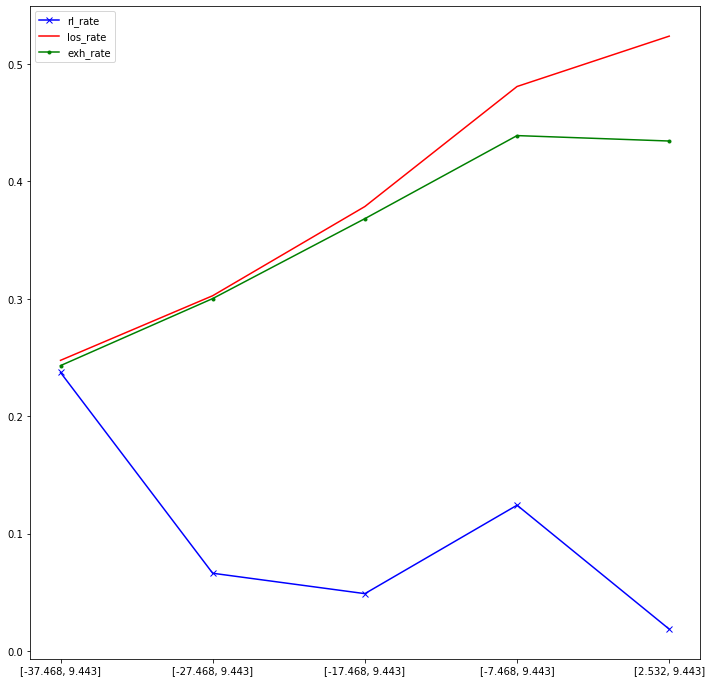

In [14]:
#Load the weights from file
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

test_episodes = 20
max_t = 5
gamma = 0.99


agent.qnetwork_local.eval()

#Plotting a random Test episode
    
learnt_rates = []
los_rates = []
exh_rates = []
ue_loc = []
state = env.reset()
learnt_val_fn = 0.0
true_val_fn = 0.0
for t in range(max_t):
    action, qval = agent.act(state)
    next_state, reward, done, _ = env.step(action)

    state = state * env.high_obs
    next_state = next_state * env.high_obs

    curr_loc = (state[0]*np.cos(state[1]), state[0]*np.sin(state[1]))
    next_loc = (next_state[0]*np.cos(next_state[1]), next_state[0]*np.sin(next_state[1]))
    #print("Test Episode: {2}, Current Location: {0}, Next Location: {1}".format(curr_loc, next_loc, i_episode))
    #print("Learnt Action: ", test_net(state))

    next_state = next_state / env.high_obs

    #rate measurements
    learnt_rate = env.get_Rate()
    _,los_rate = env.get_Los_Rate(next_state)
    exh_bdir,exh_rate = env.get_Exh_Rate(next_state)

    learnt_val_fn += ((gamma**t) * (learnt_rate))
    true_val_fn += ((gamma**t) * (exh_rate))

    print("exh dir: {0}, learnt bdir: {1}".format(exh_bdir, env.BeamSet[action]))
    print("Rwd: {3}, Learnt Rate: {0}, Exh_Rate: {1}, Los_Rate: {2}".format(learnt_rate, exh_rate, los_rate, reward))
    
    learnt_rates.append(learnt_rate)
    exh_rates.append(exh_rate)
    los_rates.append(los_rate)
    ue_loc.append(str([np.around(next_loc[0], decimals=3), np.around(next_loc[1], decimals=3)]))

fig=plt.figure(figsize=(12,12))
plt.plot(ue_loc, learnt_rates,'bx-', ue_loc, los_rates, 'r', ue_loc, exh_rates, 'g.-')
plt.legend(["rl_rate", "los_rate", "exh_rate"])
plt.show()


In [10]:
parameters = agent.qnetwork_local.parameters()
print('layer1: ', agent.qnetwork_local.hidden_layers[0].weight)
print('layer2: ', agent.qnetwork_local.hidden_layers[1].weight)
#print('layer3: ', agent.qnetwork_local.hidden_layers[2].weight)
print('output layer: ', agent.qnetwork_local.output.weight)

layer1:  Parameter containing:
tensor([[-0.2641, -0.3369, -0.0757],
        [ 1.3933,  0.8142,  0.1415],
        [ 0.9054,  1.2262,  0.0264],
        [ 1.1290, -1.4034,  0.0770],
        [ 0.6163, -0.8807,  0.0490],
        [ 0.0889,  1.0816,  0.3071],
        [ 0.4568, -1.6067, -0.0567],
        [-1.0239, -0.8388,  0.3950],
        [-0.0366, -0.2746, -0.1842],
        [-0.2961,  0.0902, -0.4403],
        [-0.5157, -0.5160,  0.1010],
        [ 0.8398, -1.0127,  0.0987],
        [-0.2954,  0.2413, -0.4074],
        [-0.9671, -0.4823,  0.0825],
        [-0.9830,  0.5585,  0.1363],
        [-0.1941,  1.3329,  0.0472],
        [-1.1064, -0.5294, -0.0281],
        [-0.3985,  0.0717,  0.0095],
        [ 0.2223, -1.0426,  0.0654],
        [-0.0740,  0.0182, -0.5927],
        [-0.2309, -0.3788, -0.2966],
        [-0.3126,  0.1681, -0.2055],
        [ 0.0053,  1.0616, -0.0973],
        [-0.0269,  1.4173, -0.0167],
        [-0.0376, -1.0653, -0.0633],
        [ 0.9316, -1.4261,  0.0087],
       